In [40]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import scipy

import matplotlib.image as mpl_img

<h2>Con que trabajamos</h2>

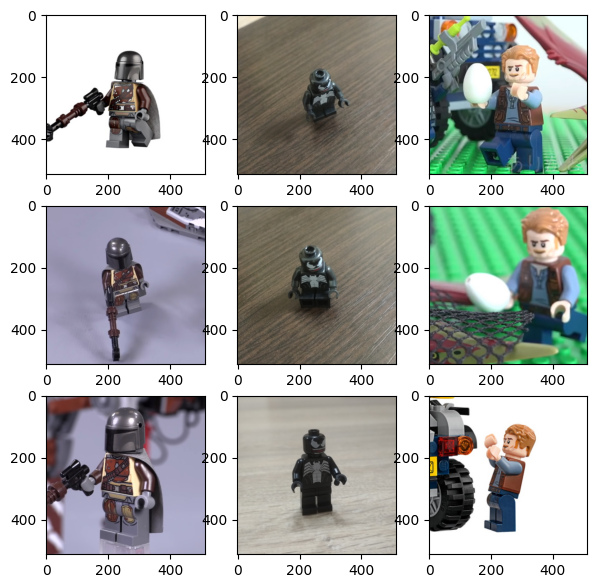

In [41]:
images = [[],[],[]]
index = ['001', '002', '003']

for i in range(3):
    images[i].append(mpl_img.imread('datasets/MINIFIGS/star-wars/0007/' + index[i] + '.jpg'))
    images[i].append(mpl_img.imread('datasets/MINIFIGS/marvel/0002/' + index[i] + '.jpg'))
    images[i].append(mpl_img.imread('datasets/MINIFIGS/jurassic-world/0001/' + index[i] + '.jpg'))

fig, axs = plt.subplots(3,3, figsize=(7,7))

for i in range(3):
    for j in range(3):
        axs[i, j].imshow(images[i][j])

dividimos en train y val

In [45]:
train_set = pd.read_csv('datasets/MINIFIGS/index.csv')
validation_set = pd.read_csv('datasets/MINIFIGS/test.csv')

<h3>Procesar imágenes</h3>

In [63]:
# Modelado de Datos
BASE = 'datasets/MINIFIGS/'

# Leer rutas de entrenamiento y prueba desde archivos CSV
train_paths = pd.read_csv(BASE + 'index.csv')
test_paths = pd.read_csv(BASE + 'test.csv')

# Inicializar listas para datos de entrenamiento y prueba
train_data = []
train_labels = np.array(train_paths['class_id']) - 1  # Restar 1 para ajustar las etiquetas

test_data = []
test_labels = np.array(test_paths['class_id']) - 1  # Restar 1 para ajustar las etiquetas

# Procesar imágenes de entrenamiento
for path in train_paths['path']:
    img = cv2.imread(str(BASE + path))
    resized_img = cv2.resize(img, (224, 224))  # Redimensionar la imagen a 224x224 píxeles
    train_data.append(resized_img)

# Procesar imágenes de prueba
for path in test_paths['path']:
    img = cv2.imread(str(BASE + path))
    resized_img = cv2.resize(img, (224, 224))  # Redimensionar la imagen a 224x224 píxeles
    test_data.append(resized_img)

# Convertir listas a arrays NumPy
train_data = np.array(train_data)
test_data = np.array(test_data)


<h3>Aumento de datos de imagen</h3>

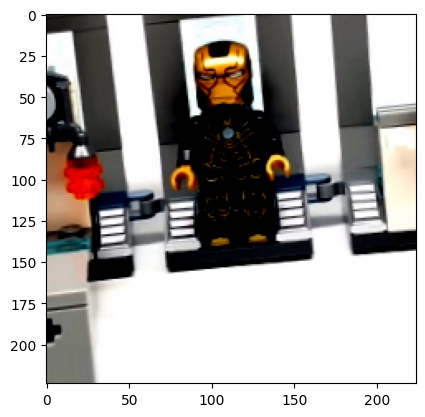

In [64]:

# Aumento de Datos de Imagen
input_preprocessor_mobilenetV2 = tf.keras.applications.mobilenet_v2.preprocess_input

imageAugmenter = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,  # Rango de rotación en grados
    zoom_range=0.2,  # Rango de zoom
    horizontal_flip=True,  # Volteo horizontal aleatorio
    preprocessing_function=input_preprocessor_mobilenetV2,  # Función de preprocesamiento
    width_shift_range=0.3,  # Desplazamiento horizontal aleatorio
    height_shift_range=0.3,  # Desplazamiento vertical aleatorio
    shear_range=0.1,  # Intensidad de deformación
    fill_mode='nearest',  # Modo de relleno para áreas fuera de la imagen después de la transformación
)

#crea un generador de datos aumentados utilizando la configuración definida anteriormente en imageAugmenter. 
training_Augmenter = imageAugmenter.flow(train_data, train_labels, batch_size=10, shuffle=True, seed=12092003)

#plt.imshow(next(training_Augmenter)[0][0])


plt.imshow(cv2.cvtColor(next(training_Augmenter)[0][0], cv2.COLOR_BGR2RGB))

<h3>Usaremos MobileNetV2 como base </h3>

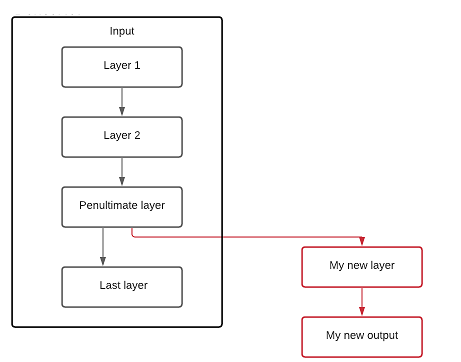

In [12]:
# Actual Model
mobilenetV2 = tf.keras.applications.mobilenet_v2.MobileNetV2(weights='imagenet')

# Se obtienen las capas de entrada y salida de MobileNetV2
base_input = mobilenetV2.input
base_output = mobilenetV2.layers[-2].output

# Se añade una capa de salida personalizada con 38 nodos y activación softmax
output = tf.keras.layers.Dense(38, activation='softmax')(base_output)

# Se crea el modelo final que toma la entrada de MobileNetV2 y produce la salida modificada.
model = tf.keras.Model(inputs=base_input, outputs=output)

# Se congelan las capas para que los pesos preentrenados no se modifiquen durante el entrenamiento adicional.
for layer in model.layers[:-1]:
    layer.trainable = False

# Se imprime un resumen del modelo, mostrando la arquitectura y el número total de parámetros.
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

<h3>Como funciona sin entrenar?</h3>

1/1 [==============================] - 9s 9s/step
Model -  pillow
Actual Image - 


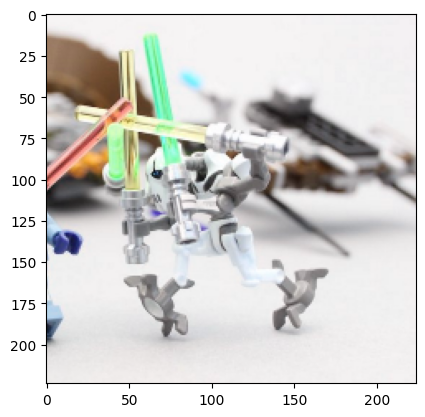

In [13]:
# MobilenetV2 predction without Training
image_number = 90
prediction = mobilenetV2.predict(train_data[image_number:image_number+1])
#se utiliza la función decode_predictions para traducir las salidas de la red neuronal en etiquetas humanamente comprensibles. 
decoder = tf.keras.applications.mobilenet_v2.decode_predictions(prediction, top=1)
number, name, probability = decoder[0][0]

print("Model - ", name)
print("Actual Image - ")
plt.imshow(train_data[image_number])

1/1 [==============================] - 6s 6s/step
Modelo -  window_screen


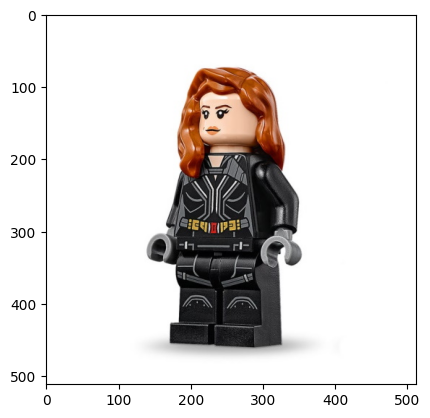

In [54]:
# Lee la imagen
num_imagen = 31

image = cv2.imread('datasets/MINIFIGS/' + validation_set["path"].values[num_imagen])

# Redimensiona la imagen a 224x224 píxeles
resized_img = cv2.resize(image, (224, 224))

# Expande las dimensiones para que coincidan con las expectativas del modelo (añade la dimensión del lote)
input_image = np.expand_dims(resized_img, axis=0)

# Realiza la predicción utilizando el modelo MobileNetV2
prediction = mobilenetV2.predict(input_image)

# Utiliza la función decode_predictions para traducir las salidas de la red neuronal en etiquetas humanamente comprensibles.
decoder = tf.keras.applications.mobilenet_v2.decode_predictions(prediction, top=1)
number, name, probability = decoder[0][0]

# Muestra la predicción
print("Modelo - ", name)

#minifigure = metadata["minifigure_name"][metadata["class_id"] == prediction].iloc[0] # find the name that matches the predicted class
#print(f"Class:\t{prediction}\tMinifigure:\t{minifigure}")


# Muestra la imagen original
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

<h2>Compilamos el modelo</h2>

In [14]:
#Model Compilation
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
optim = tf.keras.optimizers.Adam(learning_rate=0.001)
metric = ['accuracy'] # representa la fracción de instancias correctamente clasificadas.

#Después de esta compilación, el modelo estará listo para ser entrenado.
model.compile(optimizer=optim, loss=loss, metrics=metric)

<h2>Entrenamiento</h2>

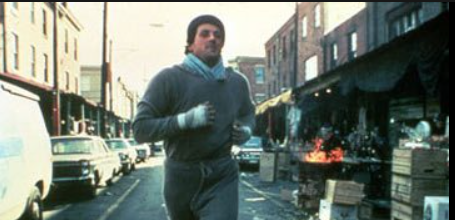

In [16]:
#Model Training

# Número de épocas para entrenar el modelo
epochs = 30

# Configuración de parada temprana para evitar sobreajuste
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss',            # Monitorea la pérdida durante el entrenamiento
    patience=3,                 # Número de épocas sin mejora antes de detener el entrenamiento
    verbose=1,                  # Muestra mensajes detallados sobre el proceso de parada temprana
    restore_best_weights=True,  # Restaura los mejores pesos del modelo cuando se detiene
)

# Entrenamiento del modelo
history = model.fit(
    training_Augmenter,         # Datos de entrenamiento generados por el ImageDataGenerator
    epochs=epochs,              # Número de épocas de entrenamiento
    verbose=1,                  # Muestra mensajes detallados durante el entrenamiento
    callbacks=[early_stopping], # Lista de devoluciones de llamada, en este caso, la parada temprana
)


Epoch 1/30
38/38 [==============================] - 33s 714ms/step - loss: 1.1680 - accuracy: 0.7493
Epoch 2/30
38/38 [==============================] - 43s 1s/step - loss: 0.8469 - accuracy: 0.8625
Epoch 3/30
38/38 [==============================] - 63s 1s/step - loss: 0.5849 - accuracy: 0.9191
Epoch 4/30
38/38 [==============================] - 26s 536ms/step - loss: 0.4685 - accuracy: 0.9407
Epoch 5/30
38/38 [==============================] - 28s 612ms/step - loss: 0.4106 - accuracy: 0.9623
Epoch 6/30
38/38 [==============================] - 23s 507ms/step - loss: 0.3444 - accuracy: 0.9677
Epoch 7/30
38/38 [==============================] - 22s 485ms/step - loss: 0.2696 - accuracy: 0.9730
Epoch 8/30
38/38 [==============================] - 21s 463ms/step - loss: 0.2428 - accuracy: 0.9784
Epoch 9/30
38/38 [==============================] - 21s 463ms/step - loss: 0.2042 - accuracy: 0.9838
Epoch 10/30
38/38 [==============================] - 20s 459ms/step - loss: 0.1779 - accuracy: 0.

In [78]:
#plt.plot(history.history['loss']) 
#plt.show()

In [79]:
#plt.plot(history.history['accuracy'])
#plt.show()

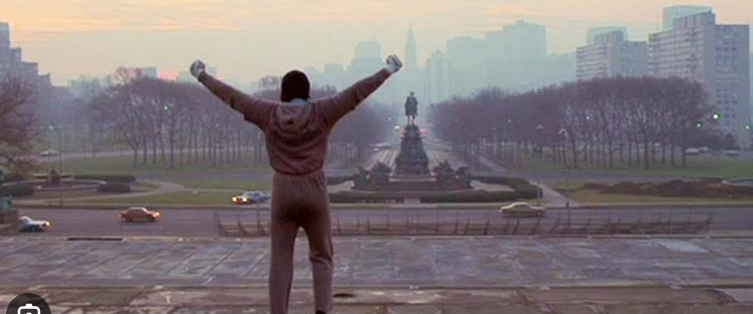

In [31]:
# Preprocesamiento de los datos de prueba utilizando la función de preprocesamiento de MobileNetV2
preprocessed_test_data = input_preprocessor_mobilenetV2(test_data)

# Evaluación del modelo en los datos de prueba
model.evaluate(preprocessed_test_data, test_labels)

3/3 [==============================] - 15s 1s/step - loss: 0.9173 - accuracy: 0.7595


[0.9172500371932983, 0.7594936490058899]

<h1>Predicciones</h1>

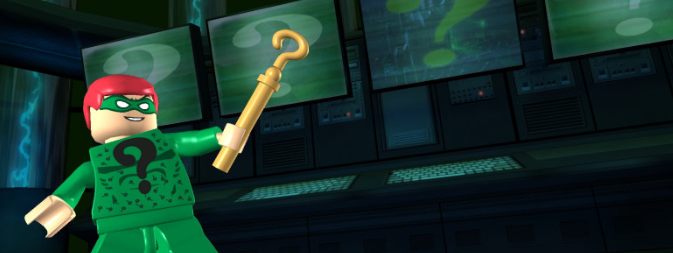

1/1 [==============================] - 6s 6s/step


Class_predicted:	26	Minifigure:	OWEN GRADY


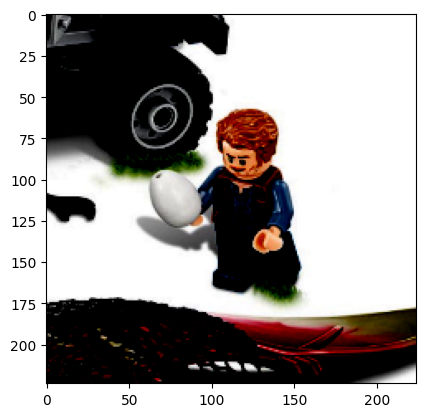

In [86]:
# Predicción
# Cambia image_number para seleccionar una imagen diferente para la predicción (0 - 78)
image_number = 23   #48 falla 

# Utiliza el modelo entrenado para predecir la clase de una única imagen de prueba
prediction = model.predict(preprocessed_test_data[image_number:image_number+1])

# Encuentra el índice de la clase con la probabilidad predicha más alta
label = np.argmax(prediction[0])

metadata = pd.read_csv('datasets/MINIFIGS/metadata.csv') # download meta data, there are store real 
                                                                                #names of minifigures

minifigure = metadata["minifigure_name"][metadata["class_id"] == label+1].iloc[0] # find the name that matches the predicted class
print(f"Class_predicted:\t{label+1}\tMinifigure:\t{minifigure}")

# Muestra la imagen de prueba seleccionada para inspección visual

img_to_color = cv2.cvtColor(preprocessed_test_data[image_number], cv2.COLOR_BGR2RGB)

plt.imshow(img_to_color)

<h3> =============================== fin =============================== </h3>

In [75]:
#save model
model.save('models/Minifigs_NN.h5')